# KAN-ODE

## KODE网络训练

### 安装依赖

In [24]:
import sys
sys.path.append('/home/sdu123/WORK/KODE')

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchdiffeq import odeint
import torch.distributions as dists
import pandas as pd
from base_kan.ekan import EKAN 

### 定义网络
包含常规ODE和Neural ODE的SIR系统

In [26]:
class CustomSIRSystem(nn.Module):
    def __init__(self, neural_part, gamma, beta):
        super(CustomSIRSystem, self).__init__()
        self.neural_part = neural_part
        self.gamma = gamma
        self.beta = beta
        self.neural_outputs = []  # 用于记录neural_output

    def forward(self, t, y):
        S, I, R = y
        neural_output = self.neural_part(torch.tensor([S, I], dtype=torch.float32).unsqueeze(0)).squeeze()
        self.neural_outputs.append(neural_output.detach().numpy())  # 记录neural_output
        dR_dt = self.gamma * I
        dI_dt = abs(neural_output) - self.gamma * I
        dS_dt = - abs (neural_output)
        return torch.stack([dS_dt, dI_dt, dR_dt])

### 初始化模型参数

In [27]:
gamma = 0.07
beta = 2 * gamma  #根据实际情况，参数beta是参数gamma的具体倍数
neural_ode_func = EKAN(layers_hidden=[2, 128, 1])
model = CustomSIRSystem(neural_ode_func, gamma, beta)

### 初始化参数

In [28]:
intial = 0.  ##时间区间的初始值
last= 160.    ##时间区间的终值
step = 160   ##时间步长
y0 = torch.tensor([0.99, 0.01, 0.0], requires_grad=True)  # 初始条件: S, I, R
t = torch.linspace(intial, last, step)  # 时间区间

### 无扰动部分

#### 生成真实数据

In [29]:
def get_data():
    gamma = 0.07
    beta = 2 * gamma
    a = 1
    true_y0 = torch.tensor([0.99, 0.01, 0.0])
    def sir(t, y):
        S, I, R = y
        dS_dt = -beta * S * I/(1 + a * I)
        dI_dt = beta * S * I/(1 + a * I)  - gamma * I
        dR_dt = gamma * I
        return torch.stack([dS_dt, dI_dt, dR_dt])
    with torch.no_grad():
        true_y = odeint(sir, true_y0, t, rtol=1e-5, atol=1e-8)
    return t, true_y

t, true_y = get_data()

#### 定义损失函数
##### 使用仅与I相关的损失函数

In [30]:
def compute_loss(pred_y, true_y):
    return torch.mean((pred_y[:, 2] - true_y[:, 2]) ** 2)

#### 定义准确率计算函数
##### 使用仅与I相关的准确率函数

In [31]:
def compute_accuracy(pred_y, true_y, threshold=0.01):
    diff = torch.abs(pred_y[:, 2] - true_y[:, 2])
    correct = (diff < threshold).float().mean()
    return correct.item()

#### 定义差分机计算公式

In [32]:
def forword_CF(x):
    # 将输入转换为tensor
    x = torch.tensor(x, dtype=torch.float32).clone().detach()
    
    # 检查输入长度是否至少为2
    if x.size(0) < 2:
        raise ValueError("Input tensor must have at least 2 elements.")
    
    # 初始化输出数列，复制第一个元素
    result = x.clone().detach()
    
    # 计算后一项减前一项
    result[1:] = x[1:] - x[:-1]
    
    return result

#### 定义训练模型
##### 执行模型的训练

In [33]:
def train():
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for itr in range(2000):
        optimizer.zero_grad()
        pred_y = odeint(model, y0, t, rtol=1e-5, atol=1e-8)
        loss = compute_loss(pred_y, true_y)
        loss.backward()
        optimizer.step()

        if itr % 100 == 0:
            accuracy = compute_accuracy(pred_y, true_y)
            print(f'Iter {itr}, Loss: {loss.item()}, Accuracy: {accuracy * 100:.2f}%')

    return t, true_y, pred_y, model.neural_outputs

#### 进行训练

In [34]:
t, True_y, pred_y, neural_outputs = train()

Iter 0, Loss: 0.03465961664915085, Accuracy: 2.50%
Iter 100, Loss: 0.0021418756805360317, Accuracy: 12.50%
Iter 200, Loss: 0.0015298655489459634, Accuracy: 15.00%
Iter 300, Loss: 0.0009394325315952301, Accuracy: 19.37%
Iter 400, Loss: 0.0004777574504259974, Accuracy: 26.25%
Iter 500, Loss: 0.0001961156231118366, Accuracy: 41.87%
Iter 600, Loss: 6.727549771312624e-05, Accuracy: 80.62%
Iter 700, Loss: 2.3329481336986646e-05, Accuracy: 92.50%
Iter 800, Loss: 1.1515851838339586e-05, Accuracy: 100.00%
Iter 900, Loss: 8.542053365090396e-06, Accuracy: 100.00%
Iter 1000, Loss: 7.508212092943722e-06, Accuracy: 100.00%
Iter 1100, Loss: 6.863012004032498e-06, Accuracy: 100.00%
Iter 1200, Loss: 6.307001513050636e-06, Accuracy: 100.00%
Iter 1300, Loss: 5.779839739261661e-06, Accuracy: 100.00%
Iter 1400, Loss: 5.277400305203628e-06, Accuracy: 100.00%
Iter 1500, Loss: 4.792398613062687e-06, Accuracy: 100.00%
Iter 1600, Loss: 4.331351647124393e-06, Accuracy: 100.00%
Iter 1700, Loss: 3.898072463925928e

##### 将A进行差分

In [35]:
True_y[:,2] = forword_CF(True_y[:,2])
pred_y[:,2] = forword_CF(pred_y[:,2])

/tmp/ipykernel_2942138/3501744976.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach()


In [36]:
t = torch.linspace(intial, last, step)  # 时间区间
def jl_get_data():
    gamma = 0.2
    beta = 2 * gamma
    true_y0 = torch.tensor([0.99, 0.01, 0.0])
    def sir(t, y):
        S, I, R = y
        dS_dt = -beta * S * (1-1/(I+1))
        dI_dt = beta * S * (1-1/(I+1)) - gamma * I
        dR_dt = gamma * I
        return torch.stack([dS_dt, dI_dt, dR_dt])
    with torch.no_grad():
        true_y = odeint(sir, true_y0, t, rtol=1e-5, atol=1e-8)
    return t, true_y

t, jl_y = jl_get_data()
jl_y[:,2] = forword_CF(jl_y[:,2])

/tmp/ipykernel_2942138/3501744976.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach()


#### 将最终数据保存至Excel

In [37]:
tdata = {
    'Time': t.numpy(),
    'True_S': True_y.numpy()[:, 0],
    'Equation_S': jl_y.numpy()[:, 1],
    'Predicted_S': pred_y.detach().numpy()[:, 0],
    'True_I': True_y.numpy()[:, 1],
    'Equation_I': jl_y.numpy()[:, 1],
    'Predicted_I': pred_y.detach().numpy()[:, 1],
    'True_R': True_y.numpy()[:, 2],
    'Equation_R': jl_y.numpy()[:, 2],
    'Predicted_R': pred_y.detach().numpy()[:, 2],
}

dft = pd.DataFrame(tdata)

##### 保存成Excel文件

In [38]:
dft.to_excel('ZS-t.xlsx', index=False)

### 加扰动部分
#### 生成真实数据

In [39]:
def get_data():
    gamma = 0.07
    beta = 2 * gamma
    a = 1
    true_y0 = torch.tensor([0.99, 0.01, 0.0])
    def sir(t, y):
        S, I, R = y
        dS_dt = -beta * S * I/(1 + a * I)
        dI_dt = beta * S * I/(1 + a * I)  - gamma * I
        dR_dt = gamma * I
        return torch.stack([dS_dt, dI_dt, dR_dt])
    with torch.no_grad():
        true_y = odeint(sir, true_y0, t, rtol=1e-5, atol=1e-8)
    return t, true_y

t, y = get_data()

#### 加入噪声

##### 泊松分布的噪声

In [40]:
# # 泊松分布的参数，lambda（λ）是泊松分布的均值和方差
y = y * 10000
# 创建泊松分布对象
poisson_dist = dists.Poisson(y)
# # 生成与原始数据相同形状的泊松噪声
poisson_noise = poisson_dist.sample()
true_y = poisson_noise/10000
y = y/10000

#### 进行训练

In [41]:
t, Z_true_y, Z_pred_y, Z_neural_outputs = train()

Iter 0, Loss: 3.9204038330353796e-05, Accuracy: 86.87%
Iter 100, Loss: 0.008422469720244408, Accuracy: 10.00%
Iter 200, Loss: 0.007088780403137207, Accuracy: 8.75%
Iter 300, Loss: 0.00657410454005003, Accuracy: 7.50%
Iter 400, Loss: 0.005948099307715893, Accuracy: 8.75%
Iter 500, Loss: 0.005264002829790115, Accuracy: 8.75%
Iter 600, Loss: 0.004580445121973753, Accuracy: 7.50%
Iter 700, Loss: 0.0039159199222922325, Accuracy: 7.50%
Iter 800, Loss: 0.0032813246361911297, Accuracy: 8.12%
Iter 900, Loss: 0.0026859757490456104, Accuracy: 10.00%
Iter 1000, Loss: 0.0021389685571193695, Accuracy: 11.25%
Iter 1100, Loss: 0.0016497329343110323, Accuracy: 11.87%
Iter 1200, Loss: 0.0012270554434508085, Accuracy: 15.00%
Iter 1300, Loss: 0.0008776203612796962, Accuracy: 17.50%
Iter 1400, Loss: 0.0006039289874024689, Accuracy: 20.62%
Iter 1500, Loss: 0.00040262675611302257, Accuracy: 28.75%
Iter 1600, Loss: 0.0002646312932483852, Accuracy: 38.75%
Iter 1700, Loss: 0.00017683712940197438, Accuracy: 48.7

##### 泊松分布扰动

In [42]:
# # 泊松分布的参数，lambda（λ）是泊松分布的均值和方差
y = True_y[:,2] * 10000
# 创建泊松分布对象
poisson_dist = dists.Poisson(y)
# # 生成与原始数据相同形状的泊松噪声
poisson_noise = poisson_dist.sample()
Z_true_y[:,2] = poisson_noise/10000

##### 差分计算

In [43]:
Z_pred_y[:,2] = forword_CF(Z_pred_y[:,2])

/tmp/ipykernel_2942138/3501744976.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach()


#### 将最终数据保存至Excel

In [44]:
tdata = {
    'Time': t.numpy(),
    'True_S': Z_true_y.numpy()[:, 0],
    'Predicted_S': Z_pred_y.detach().numpy()[:, 0],
    'True_I': Z_true_y.numpy()[:, 1],
    'Predicted_I': Z_pred_y.detach().numpy()[:, 1],
    'True_R': Z_true_y.numpy()[:, 2],
    'Predicted_R': Z_pred_y.detach().numpy()[:, 2],
}

dft = pd.DataFrame(tdata)



##### 保存成Excel文件

In [45]:
dft.to_excel('ZS-zt.xlsx', index=False)

### 绘制结果并将图片结果保存
#### 训练阶段可视化

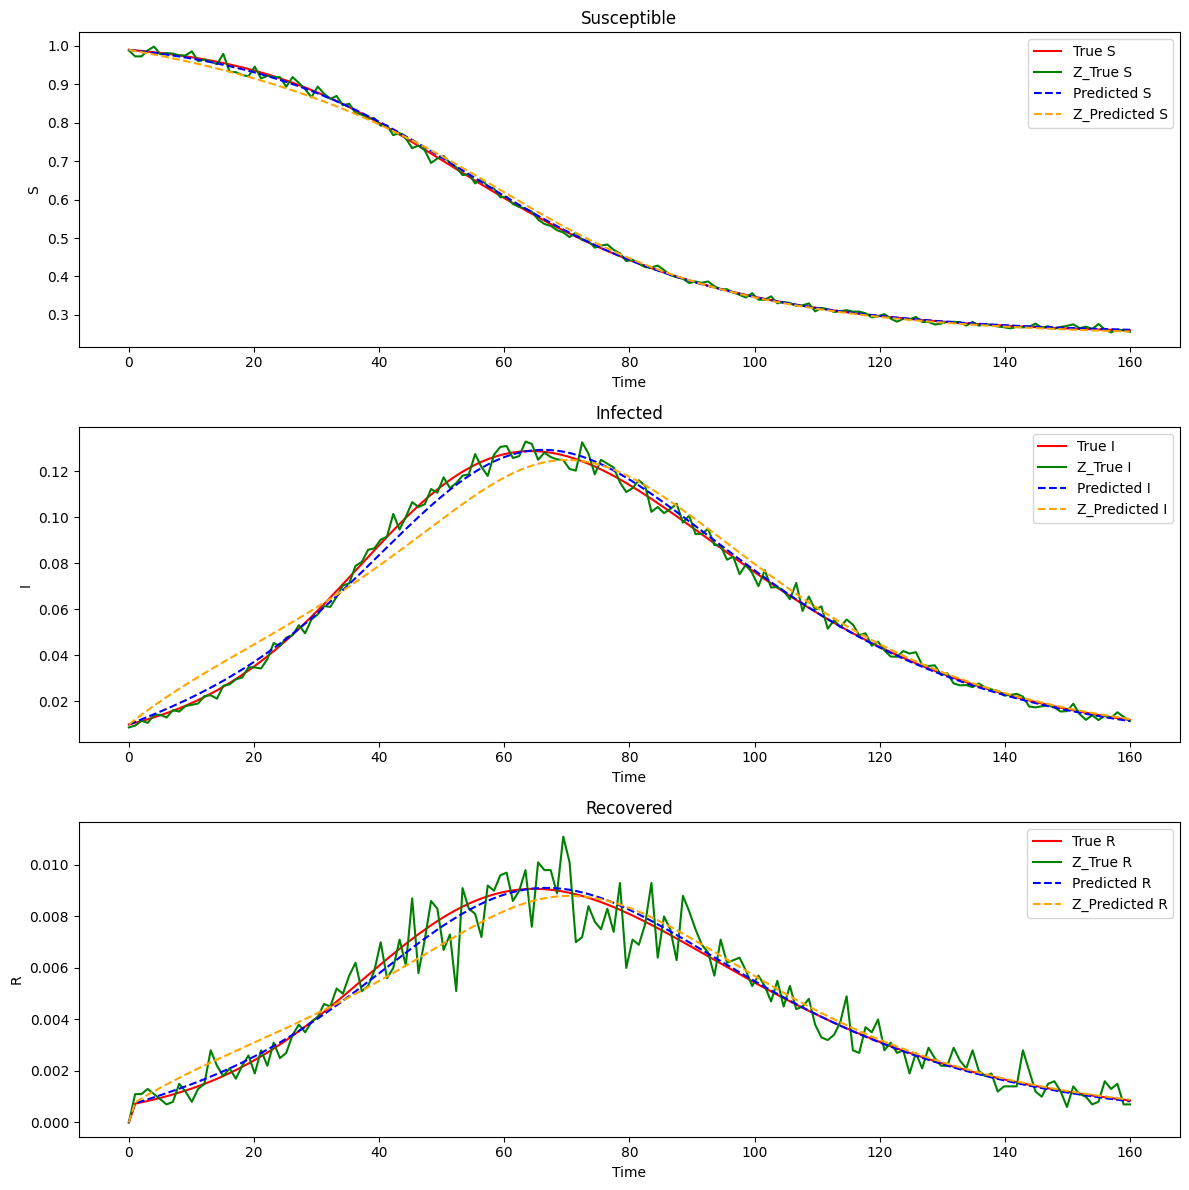

In [46]:
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(t.numpy(), True_y.numpy()[:, 0], '-', label='True S', color='red')
plt.plot(t.numpy(), Z_true_y.numpy()[:, 0], '-', label='Z_True S', color='green')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 0], '--', label='Predicted S', color='blue')
plt.plot(t.numpy(), Z_pred_y.detach().numpy()[:, 0], '--', label='Z_Predicted S', color='orange')
plt.legend()
plt.xlabel('Time')
plt.ylabel('S')
plt.title('Susceptible')

plt.subplot(3, 1, 2)
plt.plot(t.numpy(), True_y.numpy()[:, 1], '-', label='True I', color='red')
plt.plot(t.numpy(), Z_true_y.numpy()[:, 1], '-', label='Z_True I', color='green')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 1], '--', label='Predicted I', color='blue')
plt.plot(t.numpy(), Z_pred_y.detach().numpy()[:, 1], '--', label='Z_Predicted I', color='orange')
plt.legend()
plt.xlabel('Time')
plt.ylabel('I')
plt.title('Infected')

plt.subplot(3, 1, 3)
plt.plot(t.numpy(), True_y.numpy()[:, 2], '-', label='True R', color='red')
plt.plot(t.numpy(), Z_true_y.numpy()[:, 2], '-', label='Z_True R', color='green')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 2], '--', label='Predicted R', color='blue')
plt.plot(t.numpy(), Z_pred_y.detach().numpy()[:, 2], '--', label='Z_Predicted R', color='orange')
plt.legend()
plt.xlabel('Time')
plt.ylabel('R')
plt.title('Recovered')


plt.tight_layout()
plt.show()
